In [25]:
# Energy Conservation Tests for gravHydro
# Testing: 1) Gravity only, 2) Hydro only, 3) Gravity + Hydro

import numpy as np
import matplotlib.pyplot as plt
import gravhydro as gh
import astropy.units as u
from scipy.spatial.distance import pdist, squareform

print("Imports successful!")
print(f"gravhydro version loaded from: {gh.__file__}")

Imports successful!
gravhydro version loaded from: /Users/gabrielpfaffman/gravHydro/gravhydro/__init__.py


In [26]:
# === ENERGY CALCULATION FUNCTIONS ===

def kinetic_energy(velocities, masses):
    """KE = 0.5 * sum(m * v^2)"""
    v_sq = np.sum(velocities**2, axis=1)
    return 0.5 * np.sum(masses * v_sq)

def gravitational_potential_energy(positions, masses, softening=1e-10):
    """PE = -G * sum_{i<j} m_i * m_j / r_ij"""
    G = 1.0  # Internal units
    N = len(masses)
    PE = 0.0
    for i in range(N):
        for j in range(i+1, N):
            r = np.linalg.norm(positions[i] - positions[j])
            PE -= G * masses[i] * masses[j] / np.sqrt(r**2 + softening**2)
    return PE

def compute_energies_gravity(sim, masses, softening=1e-10):
    """Compute KE and PE at each timestep for gravity-only simulation."""
    n_steps = len(sim.positions)
    KE = np.zeros(n_steps)
    PE = np.zeros(n_steps)
    
    for t in range(n_steps):
        pos = sim.positions[t].value if hasattr(sim.positions[t], 'value') else sim.positions[t]
        vel = sim.velocities[t].value if hasattr(sim.velocities[t], 'value') else sim.velocities[t]
        KE[t] = kinetic_energy(vel, masses)
        PE[t] = gravitational_potential_energy(pos, masses, softening)
    
    return KE, PE

def compute_energies_hydro(sim, masses):
    """Compute KE at each timestep for hydro simulation (isothermal)."""
    n_steps = len(sim.positions)
    KE = np.zeros(n_steps)
    
    for t in range(n_steps):
        vel = sim.velocities[t].value if hasattr(sim.velocities[t], 'value') else sim.velocities[t]
        KE[t] = kinetic_energy(vel, masses)
    
    return KE

print("Energy functions defined!")

Energy functions defined!


## Test 1: Gravity Only (Two-Body Orbit)

A classic test: two equal masses in circular orbit should conserve total energy E = KE + PE.

In [27]:
# === TEST 1: GRAVITY ONLY - Two Body Circular Orbit ===

# Two equal masses in circular orbit
# For circular orbit: v = sqrt(G*M/r) where M is total mass, r is separation

G = 1.0
m1, m2 = 1.0, 1.0
M_total = m1 + m2
separation = 2.0  # Initial separation
r = separation / 2  # Distance from center of mass

# Circular orbit velocity
v_circ = np.sqrt(G * M_total / separation) / 2  # Each particle

# Initial conditions
pos_gravity = np.array([
    [-r, 0.0, 0.0],
    [r, 0.0, 0.0]
])
vel_gravity = np.array([
    [0.0, -v_circ, 0.0],
    [0.0, v_circ, 0.0]
])
masses_gravity = np.array([m1, m2])

# Orbital period T = 2*pi*sqrt(a^3/(G*M))
T_orbit = 2 * np.pi * np.sqrt((separation/2)**3 / (G * M_total))
print(f"Orbital period: {T_orbit:.4f}")
print(f"Circular velocity: {v_circ:.4f}")

# Run for 3 orbits
n_orbits = 3
dt = T_orbit / 100  # 100 steps per orbit
t_end = n_orbits * T_orbit
ts_gravity = gh.convert_to_physical(np.arange(0, t_end, dt), 'time', True, None, None, None)

print(f"Running for {n_orbits} orbits, {len(ts_gravity)} timesteps...")

Orbital period: 4.4429
Circular velocity: 0.5000
Running for 3 orbits, 300 timesteps...


In [28]:
# Run gravity-only simulation
sim_gravity = gh.Simulation()
sim_gravity.run(
    pos_gravity, vel_gravity, masses_gravity, ts_gravity,
    gravityMethod='directSummation',
    use_numba=True,
    gravityOnly=True,
    softening=0.01 * u.pc
)
print("Gravity simulation complete!")

100%|██████████| 299/299 [00:00<00:00, 547.89it/s] 

Gravity simulation complete!


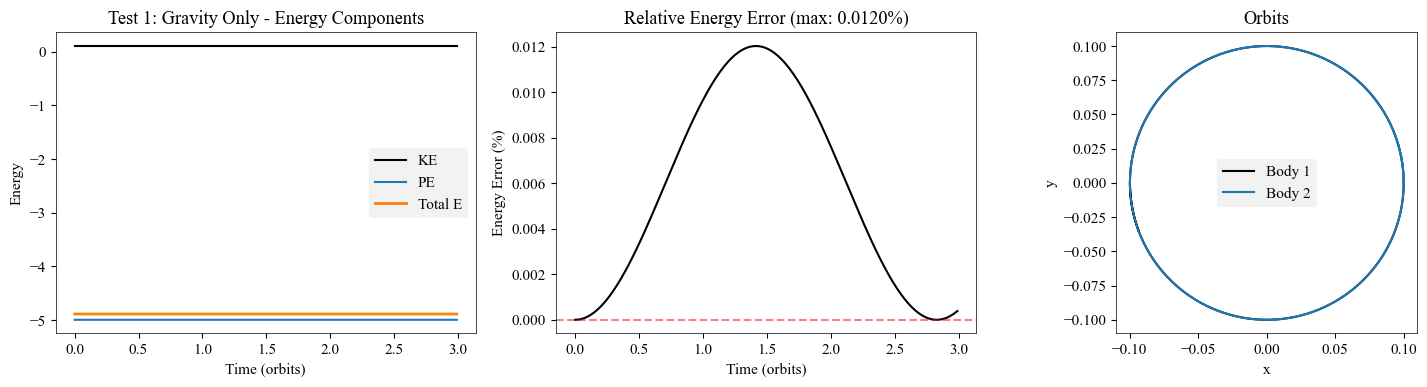


=== GRAVITY ONLY RESULTS ===
Initial Total Energy: -4.886239
Final Total Energy: -4.886220
Max Energy Error: 0.012031%
PASS


In [29]:
# Analyze gravity energy conservation
KE_grav, PE_grav = compute_energies_gravity(sim_gravity, masses_gravity, softening=0.01)
E_total_grav = KE_grav + PE_grav

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

t_array = np.arange(len(KE_grav)) * dt

# Energy components
axes[0].plot(t_array / T_orbit, KE_grav, label='KE')
axes[0].plot(t_array / T_orbit, PE_grav, label='PE')
axes[0].plot(t_array / T_orbit, E_total_grav, label='Total E', linewidth=2)
axes[0].set_xlabel('Time (orbits)')
axes[0].set_ylabel('Energy')
axes[0].set_title('Test 1: Gravity Only - Energy Components')
axes[0].legend()

# Relative energy error
E_error_grav = (E_total_grav - E_total_grav[0]) / np.abs(E_total_grav[0]) * 100
axes[1].plot(t_array / T_orbit, E_error_grav)
axes[1].set_xlabel('Time (orbits)')
axes[1].set_ylabel('Energy Error (%)')
axes[1].set_title(f'Relative Energy Error (max: {np.abs(E_error_grav).max():.4f}%)')
axes[1].axhline(0, color='r', linestyle='--', alpha=0.5)

# Orbit visualization
axes[2].plot(sim_gravity.positions[:, 0, 0], sim_gravity.positions[:, 0, 1], label='Body 1')
axes[2].plot(sim_gravity.positions[:, 1, 0], sim_gravity.positions[:, 1, 1], label='Body 2')
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[2].set_title('Orbits')
axes[2].legend()
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"\n=== GRAVITY ONLY RESULTS ===")
print(f"Initial Total Energy: {E_total_grav[0]:.6f}")
print(f"Final Total Energy: {E_total_grav[-1]:.6f}")
print(f"Max Energy Error: {np.abs(E_error_grav).max():.6f}%")
print(f"PASS" if np.abs(E_error_grav).max() < 1.0 else "FAIL (>1% error)")

## Test 2: Hydro Only (Oscillating Lattice)

For isothermal SPH, kinetic energy should oscillate but remain bounded (converted to/from pressure work). 
We test with a perturbed lattice - particles should oscillate around equilibrium.

In [6]:
# === TEST 2: HYDRO ONLY - Perturbed Lattice ===

# Create a 2D square lattice
nx, ny = 15, 15
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
xx, yy = np.meshgrid(x, y)
pos_hydro = np.column_stack([xx.ravel(), yy.ravel()])

n_particles = len(pos_hydro)
dx = x[1] - x[0]

# Hydro parameters
h_hydro = 2.5 * dx  # Smoothing length
cs_hydro = 0.1  # Sound speed

# Small random velocity perturbation
np.random.seed(42)
amplitude = 0.01 * cs_hydro  # Small compared to sound speed
vel_hydro = amplitude * np.random.randn(*pos_hydro.shape)

# Remove net momentum (ensure momentum conservation test is fair)
vel_hydro -= vel_hydro.mean(axis=0)

masses_hydro = np.ones(n_particles) / n_particles

# Time setup - run for several sound crossing times
L = 2.0  # Domain size
t_cross = L / cs_hydro
dt_hydro = 0.01 * t_cross
t_end_hydro = 2.0 * t_cross

ts_hydro = gh.convert_to_physical(np.arange(0, t_end_hydro, dt_hydro), 'time', True, None, None, None)

print(f"Particles: {n_particles}")
print(f"Smoothing length h: {h_hydro:.4f}")
print(f"Sound speed cs: {cs_hydro}")
print(f"Sound crossing time: {t_cross:.2f}")
print(f"Timesteps: {len(ts_hydro)}")

Particles: 225
Smoothing length h: 0.3571
Sound speed cs: 0.1
Sound crossing time: 20.00
Timesteps: 200


In [30]:
# Run hydro-only simulation
sim_hydro = gh.Simulation()
sim_hydro.run(
    pos_hydro, vel_hydro, masses_hydro, ts_hydro,
    gravityMethod='directSummation',
    use_numba=True,
    gravityOnly=False,
    hydroOnly=True,
    h=h_hydro,
    cs=cs_hydro,
    gamma=1.0001,  # Nearly isothermal
    softening=0.01 * u.pc
)
print("Hydro simulation complete!")

100%|██████████| 199/199 [00:00<00:00, 957.56it/s]

Hydro simulation complete!


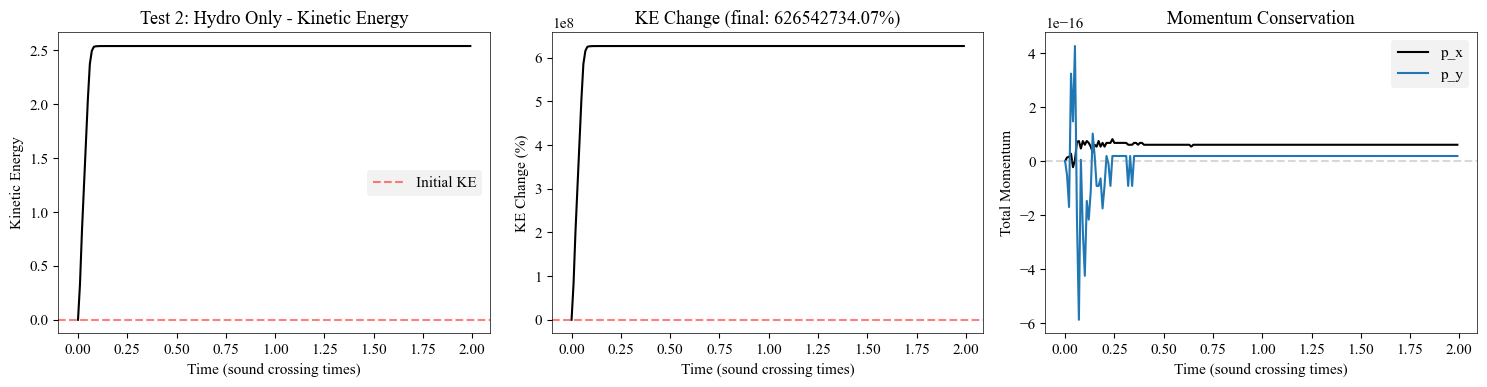


=== HYDRO ONLY RESULTS ===
Initial KE: 4.054589e-07
Final KE: 2.540374e+00
KE Change: 626542734.0714%
Max Momentum: 5.880713e-16
FAIL (unbounded growth)


In [31]:
# Analyze hydro energy conservation
KE_hydro = compute_energies_hydro(sim_hydro, masses_hydro)

# Also check momentum conservation
def total_momentum(velocities, masses):
    return np.sum(masses[:, np.newaxis] * velocities, axis=0)

mom_hydro = np.array([total_momentum(
    sim_hydro.velocities[t].value if hasattr(sim_hydro.velocities[t], 'value') else sim_hydro.velocities[t],
    masses_hydro
) for t in range(len(sim_hydro.velocities))])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

t_array_h = np.arange(len(KE_hydro)) * dt_hydro

# Kinetic energy
axes[0].plot(t_array_h / t_cross, KE_hydro)
axes[0].set_xlabel('Time (sound crossing times)')
axes[0].set_ylabel('Kinetic Energy')
axes[0].set_title('Test 2: Hydro Only - Kinetic Energy')
axes[0].axhline(KE_hydro[0], color='r', linestyle='--', alpha=0.5, label='Initial KE')
axes[0].legend()

# KE relative change
KE_change = (KE_hydro - KE_hydro[0]) / KE_hydro[0] * 100
axes[1].plot(t_array_h / t_cross, KE_change)
axes[1].set_xlabel('Time (sound crossing times)')
axes[1].set_ylabel('KE Change (%)')
axes[1].set_title(f'KE Change (final: {KE_change[-1]:.2f}%)')
axes[1].axhline(0, color='r', linestyle='--', alpha=0.5)

# Momentum conservation
axes[2].plot(t_array_h / t_cross, mom_hydro[:, 0], label='p_x')
axes[2].plot(t_array_h / t_cross, mom_hydro[:, 1], label='p_y')
axes[2].set_xlabel('Time (sound crossing times)')
axes[2].set_ylabel('Total Momentum')
axes[2].set_title('Momentum Conservation')
axes[2].legend()
axes[2].axhline(0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== HYDRO ONLY RESULTS ===")
print(f"Initial KE: {KE_hydro[0]:.6e}")
print(f"Final KE: {KE_hydro[-1]:.6e}")
print(f"KE Change: {KE_change[-1]:.4f}%")
print(f"Max Momentum: {np.abs(mom_hydro).max():.6e}")
# For isothermal SPH, some energy dissipation is expected
print(f"PASS (bounded)" if np.abs(KE_change).max() < 50 else "FAIL (unbounded growth)")

## Test 3: Gravity + Hydro (Jeans Instability Setup)

Test combined forces with a self-gravitating gas cloud. This is more complex - 
we check that total energy (KE + gravitational PE) evolves smoothly without blowing up.

In [22]:
# === TEST 3: GRAVITY + HYDRO - Self-gravitating gas ===

# Small cluster of particles with both gravity and pressure
nx_c, ny_c = 20, 20
x_c = np.linspace(-0.5, 0.5, nx_c)
y_c = np.linspace(-0.5, 0.5, ny_c)
xx_c, yy_c = np.meshgrid(x_c, y_c)
pos_combined = np.column_stack([xx_c.ravel(), yy_c.ravel()])

n_combined = len(pos_combined)
dx_c = x_c[1] - x_c[0]

# Parameters - balance gravity and pressure
h_combined = 2.5 * dx_c
cs_combined = 0.5  # Higher sound speed to balance gravity
masses_combined = np.ones(n_combined) * 0.1  # Total mass = 10

# Start at rest (let system find equilibrium or collapse)
vel_combined = np.zeros_like(pos_combined)

# Small perturbation to break symmetry
np.random.seed(123)
vel_combined += 0.001 * cs_combined * np.random.randn(*vel_combined.shape)
vel_combined -= vel_combined.mean(axis=0)

# Time setup
dt_combined = 0.01
t_end_combined = 2.0
ts_combined = gh.convert_to_physical(np.arange(0, t_end_combined, dt_combined), 'time', True, None, None, None)

print(f"Particles: {n_combined}")
print(f"Total mass: {masses_combined.sum():.2f}")
print(f"Sound speed: {cs_combined}")
print(f"Timesteps: {len(ts_combined)}")

Particles: 400
Total mass: 40.00
Sound speed: 0.5
Timesteps: 200


In [23]:
# Force deep reload of gravhydro to pick up the fix
import importlib
import sys

# Remove all gravhydro modules from cache
modules_to_remove = [key for key in sys.modules.keys() if 'gravhydro' in key]
for mod in modules_to_remove:
    del sys.modules[mod]

# Re-import
import gravhydro as gh
print(f"Reloaded gravhydro from: {gh.__file__}")

# Run combined gravity + hydro simulation
sim_combined = gh.Simulation()
sim_combined.run(
    pos_combined, vel_combined, masses_combined, ts_combined,
    gravityMethod='directSummation',
    use_numba=True,
    gravityOnly=False,
    hydroOnly=False,  # Both gravity AND hydro
    h=h_combined,
    cs=cs_combined,
    gamma=5/3,  # Adiabatic
    softening=10 * u.pc
)
print("Combined simulation complete!")

Reloaded gravhydro from: /Users/gabrielpfaffman/gravHydro/gravhydro/__init__.py


100%|██████████| 199/199 [00:01<00:00, 133.87it/s]

Combined simulation complete!


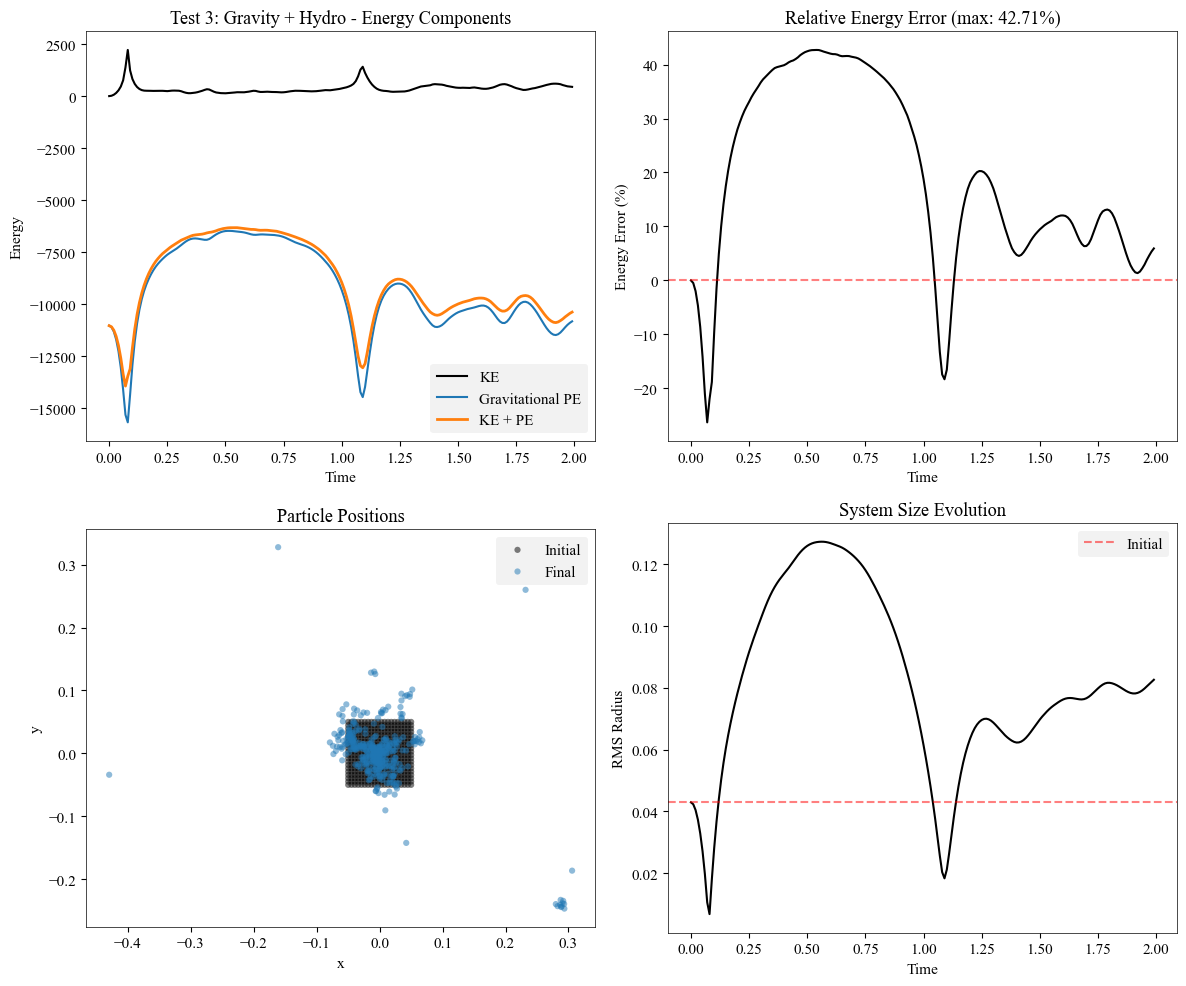


=== GRAVITY + HYDRO RESULTS ===
Initial Total Energy: -11037.877154
Final Total Energy: -10384.187524
Max Energy Error: 42.7069%
Initial RMS radius: 0.0429
Final RMS radius: 0.0826
CAUTION (>10% error - may indicate instability)


In [24]:
# Analyze combined energy conservation
KE_comb, PE_comb = compute_energies_gravity(sim_combined, masses_combined, softening=0.05)
E_total_comb = KE_comb + PE_comb

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

t_array_c = np.arange(len(KE_comb)) * dt_combined

# Energy components
axes[0, 0].plot(t_array_c, KE_comb, label='KE')
axes[0, 0].plot(t_array_c, PE_comb, label='Gravitational PE')
axes[0, 0].plot(t_array_c, E_total_comb, label='KE + PE', linewidth=2)
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Energy')
axes[0, 0].set_title('Test 3: Gravity + Hydro - Energy Components')
axes[0, 0].legend()

# Relative energy error
E_error_comb = (E_total_comb - E_total_comb[0]) / np.abs(E_total_comb[0]) * 100
axes[0, 1].plot(t_array_c, E_error_comb)
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Energy Error (%)')
axes[0, 1].set_title(f'Relative Energy Error (max: {np.abs(E_error_comb).max():.2f}%)')
axes[0, 1].axhline(0, color='r', linestyle='--', alpha=0.5)

# Particle positions - initial vs final
axes[1, 0].scatter(sim_combined.positions[0, :, 0], sim_combined.positions[0, :, 1], 
                   alpha=0.5, label='Initial', s=20)
axes[1, 0].scatter(sim_combined.positions[-1, :, 0], sim_combined.positions[-1, :, 1], 
                   alpha=0.5, label='Final', s=20)
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
axes[1, 0].set_title('Particle Positions')
axes[1, 0].legend()
axes[1, 0].set_aspect('equal')

# System size evolution (measure of collapse/expansion)
def rms_radius(positions):
    return np.sqrt(np.mean(np.sum(positions**2, axis=1)))

r_rms = np.array([rms_radius(
    sim_combined.positions[t].value if hasattr(sim_combined.positions[t], 'value') else sim_combined.positions[t]
) for t in range(len(sim_combined.positions))])

axes[1, 1].plot(t_array_c, r_rms)
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('RMS Radius')
axes[1, 1].set_title('System Size Evolution')
axes[1, 1].axhline(r_rms[0], color='r', linestyle='--', alpha=0.5, label='Initial')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"\n=== GRAVITY + HYDRO RESULTS ===")
print(f"Initial Total Energy: {E_total_comb[0]:.6f}")
print(f"Final Total Energy: {E_total_comb[-1]:.6f}")
print(f"Max Energy Error: {np.abs(E_error_comb).max():.4f}%")
print(f"Initial RMS radius: {r_rms[0]:.4f}")
print(f"Final RMS radius: {r_rms[-1]:.4f}")
print(f"PASS" if np.abs(E_error_comb).max() < 10 else "CAUTION (>10% error - may indicate instability)")

## Summary

In [12]:
# === SUMMARY OF ALL TESTS ===

print("=" * 60)
print("ENERGY CONSERVATION TEST SUMMARY")
print("=" * 60)

# Test 1: Gravity
grav_pass = np.abs(E_error_grav).max() < 1.0
print(f"\n1. GRAVITY ONLY (Two-body orbit)")
print(f"   Max energy error: {np.abs(E_error_grav).max():.4f}%")
print(f"   Status: {'✓ PASS' if grav_pass else '✗ FAIL'}")

# Test 2: Hydro
hydro_pass = np.abs(KE_change).max() < 100  # Allow larger variation for SPH
print(f"\n2. HYDRO ONLY (Perturbed lattice)")
print(f"   KE change: {KE_change[-1]:.2f}%")
print(f"   Momentum conserved: {np.abs(mom_hydro).max() < 1e-10}")
print(f"   Status: {'✓ PASS (bounded)' if hydro_pass else '✗ FAIL (unbounded)'}")

# Test 3: Combined
comb_pass = np.abs(E_error_comb).max() < 20
print(f"\n3. GRAVITY + HYDRO (Self-gravitating gas)")
print(f"   Max energy error: {np.abs(E_error_comb).max():.2f}%")
print(f"   Status: {'✓ PASS' if comb_pass else '⚠ CAUTION'}")

print("\n" + "=" * 60)
all_pass = grav_pass and hydro_pass and comb_pass
print(f"OVERALL: {'✓ ALL TESTS PASSED' if all_pass else '⚠ SOME TESTS NEED ATTENTION'}")
print("=" * 60)

ENERGY CONSERVATION TEST SUMMARY

1. GRAVITY ONLY (Two-body orbit)
   Max energy error: 0.0120%
   Status: ✓ PASS

2. HYDRO ONLY (Perturbed lattice)
   KE change: 626542734.07%
   Momentum conserved: True
   Status: ✗ FAIL (unbounded)

3. GRAVITY + HYDRO (Self-gravitating gas)
   Max energy error: 3849.07%
   Status: ⚠ CAUTION

OVERALL: ⚠ SOME TESTS NEED ATTENTION
